<u>Imports</u>

In [1]:
# Standard
import pandas as pd
import numpy as np

# Scrapping
from selenium import webdriver # Version == 4.22.0
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.common.exceptions import TimeoutException

# Dataset preparation
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Modelling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Visualisation
import matplotlib.pyplot as plt

<u>Scrapping</u>

In [2]:
url = 'https://www.windguru.cz/112'
num_prev = 100 # Number of observations to be collected from Windguru

In [3]:
class Scraper:

    def __init__(self, url):
        self.url = url
        self.driver = webdriver.Chrome()
        self.driver.get(self.url)
        
    def scrape(self, num_prev):

        """
        Scrapes forecast data for a specified number of observations (1 observation = 2-hour period)
        Args:
        * num_prev: Number of forecast periods to scrape.
        Returns:
        * A pandas DataFrame containing the scraped forecast data:
            - Date & hour of estimate
            - Wind and gust speed and direction
            - Swell height, period and direction
        """ 

        # Wait for the browsed page before scraping
        try:
            myElem = WebDriverWait(self.driver, 5).until(expected_conditions.presence_of_element_located((By.XPATH, '//*[@id="tabid_0_0_dates"]/td[1]')))
        except TimeoutException:
            None
        
        forecast = {}

        parse_number = lambda x: int(''.join([l for l in str(x) if l.isdigit()]))

        # Extract datetime
        temp_list = []
        for i in range(1, num_prev + 1):
            try:
                value = self.driver.find_element(By.XPATH, f'//*[@id="tabid_0_0_dates"]/td[{i}]')
                temp_list.append(value.text)
            except Exception as e:
                temp_list.append(pd.NA)
        forecast['date'] = temp_list

        # Extract numeric figures 
        for name in ['tabid_0_0_WINDSPD','tabid_0_0_GUST','tabid_0_0_HTSGW', 'tabid_0_0_PERPW'] :
            temp_list = []
            for i in range(1, num_prev + 1):
                try:
                    value = self.driver.find_element(By.XPATH, f'//*[@id="{name}"]/td[{i}]')
                    numeric_value = float(value.text.strip())  # Convert text to float
                    temp_list.append(numeric_value)
                except Exception as e:
                    temp_list.append(pd.NA)
            forecast[name] = temp_list

        # Extract angles        
        for name in ['tabid_0_0_SMER','tabid_0_0_DIRPW']:
            temp_list = []
            for i in range(1, num_prev + 1):
                try:
                    value = self.driver.find_element(By.XPATH, f'//*[@id="{name}"]/td[{i}]/span')
                    numeric_value = parse_number(value.get_attribute('title'))
                    temp_list.append(numeric_value)
                except Exception as e:
                    temp_list.append(pd.NA)
            forecast[name] = temp_list
        
        forecast_df=pd.DataFrame(forecast)
        
        # Formatting 
        forecast_df.dropna(inplace=True)
        forecast_df.columns = ['date','wind_speed','gust_speed','swell_height','swell_period','wind_dir','swell_dir']
        forecast_df['wind_speed'] = forecast_df[['wind_speed', 'gust_speed']].mean(axis=1)
        forecast_df = forecast_df.drop(columns=['gust_speed'])
        forecast_df[['wind_speed','swell_period']] = forecast_df[['wind_speed','swell_period']].astype(int)
        
        return forecast_df

In [4]:
scraper = Scraper(url)
forecast_df = scraper.scrape(num_prev = num_prev)

In [5]:
forecast_df

,date,wind_speed,swell_height,swell_period,wind_dir,swell_dir
0,Mo\n1.\n14h,12,0.5,4,313,313
1,Mo\n1.\n16h,14,0.5,3,301,306
2,Mo\n1.\n18h,15,0.8,4,307,306
3,Mo\n1.\n20h,16,0.7,4,303,304
4,Mo\n1.\n22h,18,0.7,4,296,300
...,...,...,...,...,...,...
95,Su\n14.\n14h,9,0.4,3,21,26
96,Su\n14.\n17h,11,0.5,3,21,30
97,Su\n14.\n20h,13,0.5,3,17,27
98,Mo\n15.\n05h,13,0.6,4,49,38


<u>Dataset preparation</u>

In [65]:
dataset = pd.read_csv('../data/dataset_rochebonne.csv')
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)
dataset.head()

,wind_speed,wind_dir,swell_height,swell_period,swell_dir,note
0,10,18,0.9,9,341,2
1,5,180,0.6,11,227,3
2,4,289,0.4,8,311,1
3,15,268,0.9,12,108,0
4,15,130,0.6,9,126,0


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wind_speed    688 non-null    int64  
 1   wind_dir      688 non-null    int64  
 2   swell_height  688 non-null    float64
 3   swell_period  688 non-null    int64  
 4   swell_dir     688 non-null    int64  
 5   note          688 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 32.4 KB


In [8]:
dataset.describe()

,wind_speed,wind_dir,swell_height,swell_period,swell_dir,note
count,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,9.758721,182.747093,0.776017,9.068314,180.498547,1.540698
std,8.656971,101.026017,0.251674,2.510470,106.167496,1.134904
min,0.000000,0.000000,0.100000,1.000000,0.000000,0.000000
25%,4.000000,99.750000,0.600000,8.000000,89.750000,1.000000
50%,8.000000,177.000000,0.800000,9.000000,177.000000,2.000000
75%,13.000000,267.250000,0.900000,11.000000,273.000000,3.000000
max,40.000000,360.000000,1.800000,17.000000,359.000000,3.000000


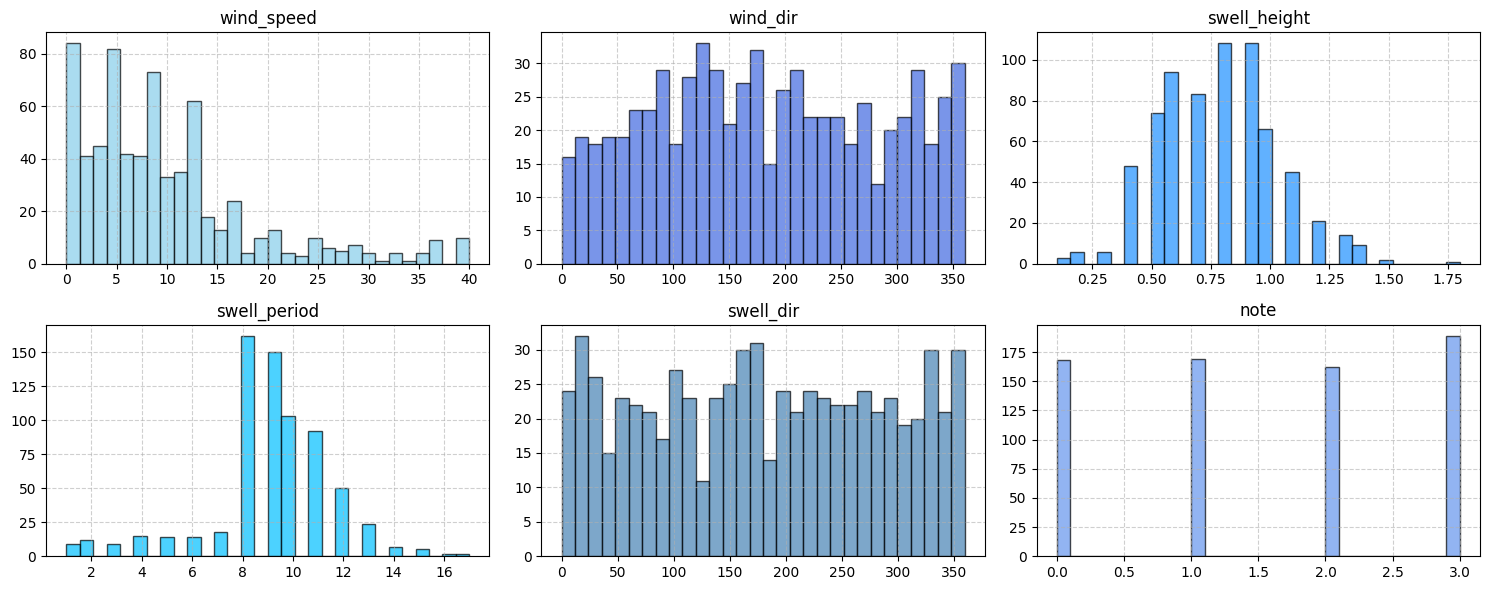

In [9]:
# Plot distribution

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))
columns = ['wind_speed', 'wind_dir', 'swell_height', 'swell_period', 'swell_dir', 'note']
colors = ['skyblue', 'royalblue', 'dodgerblue', 'deepskyblue', 'steelblue', 'cornflowerblue']

for ax, col, color in zip(axes.flatten(), columns, colors):
    ax.hist(dataset[col], bins=30, color=color, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [10]:
dataset.note.value_counts()

note
3    189
1    169
0    168
2    162
Name: count, dtype: int64

In [11]:
# Split X and y

y = dataset['note']
X = dataset.drop(columns=['note'])

In [12]:
# Split test and train sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Scale data 

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['wind_speed', 'wind_dir', 'swell_dir']] = minmax_scaler.fit_transform(X_train[['wind_speed', 'wind_dir', 'swell_dir']])
X_test_scaled[['wind_speed', 'wind_dir', 'swell_dir']] = minmax_scaler.transform(X_test[['wind_speed', 'wind_dir', 'swell_dir']])

X_train_scaled[['swell_height', 'swell_period']] = standard_scaler.fit_transform(X_train[['swell_height', 'swell_period']])
X_test_scaled[['swell_height', 'swell_period']] = standard_scaler.transform(X_test[['swell_height', 'swell_period']])

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class Preprocessor:
    def __init__(self):
        self.preprocessor = ColumnTransformer(transformers=[
            ('minmax_scaler', MinMaxScaler(), ['wind_speed', 'wind_dir', 'swell_dir']),
            ('standard_scaler', StandardScaler(), ['swell_height', 'swell_period'])
        ], remainder='passthrough')

    def fit(self, X):
        self.preprocessor.fit(X)
        return self

    def transform(self, X):
        X_scaled = pd.DataFrame(self.preprocessor.transform(X))
        X_scaled.columns = X.columns
        return X_scaled

In [15]:
preprocessor = Preprocessor()

In [16]:
preprocessor.fit(X_train)

In [17]:
X_test_scaled2 = preprocessor.transform(X_test)

In [18]:
X_test_scaled2

,wind_speed,wind_dir,swell_height,swell_period,swell_dir
0,0.250,0.050000,0.949861,0.483909,-0.029161
1,0.125,0.500000,0.632312,-0.711375,0.772756
2,0.100,0.802778,0.866295,-1.508230,-0.430119
3,0.375,0.744444,0.300836,0.483909,1.173714
4,0.375,0.361111,0.350975,-0.711375,-0.029161
...,...,...,...,...,...
133,0.000,0.908333,0.855153,0.085481,-0.430119
134,0.475,0.333333,0.286908,0.882336,-0.029161
135,0.325,0.047222,0.860724,-1.109802,1.173714
136,0.100,0.394444,0.493036,-0.711375,-0.029161


In [19]:
X_test_scaled

,wind_speed,wind_dir,swell_height,swell_period,swell_dir
286,0.250,0.050000,0.483909,-0.029161,0.949861
654,0.125,0.500000,-0.711375,0.772756,0.632312
257,0.100,0.802778,-1.508230,-0.430119,0.866295
336,0.375,0.744444,0.483909,1.173714,0.300836
318,0.375,0.361111,-0.711375,-0.029161,0.350975
...,...,...,...,...,...
333,0.000,0.908333,0.085481,-0.430119,0.855153
506,0.475,0.333333,0.882336,-0.029161,0.286908
24,0.325,0.047222,-1.109802,1.173714,0.860724
158,0.100,0.394444,-0.711375,-0.029161,0.493036


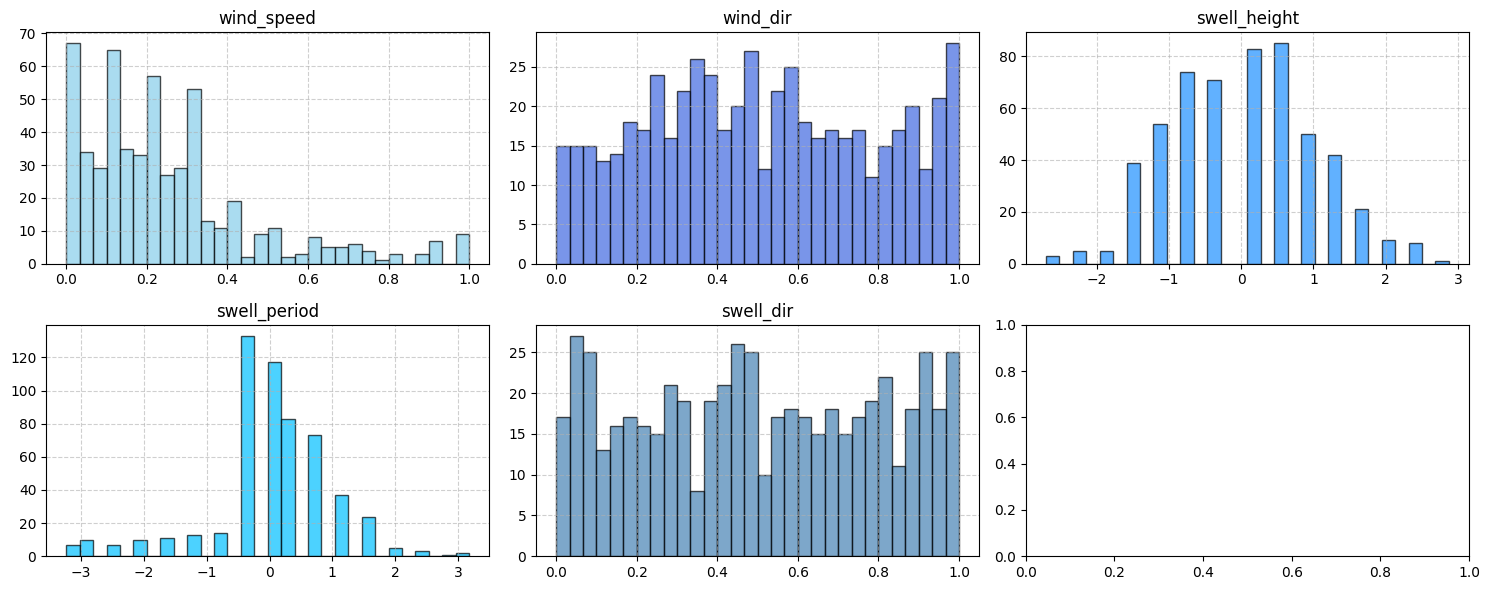

In [20]:
# Plot distribution

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))
columns = ['wind_speed', 'wind_dir', 'swell_height', 'swell_period', 'swell_dir']
colors = ['skyblue', 'royalblue', 'dodgerblue', 'deepskyblue', 'steelblue']

for ax, col, color in zip(axes.flatten(), columns, colors):
    ax.hist(X_train_scaled[col], bins=30, color=color, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

<u>Modelling</u>

Comparison of the following:
- Logistic Regression,
- Decision Tree,
- Random Forest,
- KNN,
- XGBoost,
- Naïve Bayes,
- Support Vector Machines

In [21]:
accuracy = {} # Store the performance of each model

1- Logistic Regression

In [22]:
logistic_model = LogisticRegression(solver='newton-cg')

In [23]:
cv_results_log = cross_validate(logistic_model, X_train_scaled, y_train, scoring = 'accuracy', cv=5)
cv_results_log

{'fit_time': array([0.07654977, 0.01283407, 0.0172081 , 0.01100707, 0.01329994]),
 'score_time': array([0.01275921, 0.00399899, 0.00401306, 0.0026741 , 0.00763798]),
 'test_score': array([0.61818182, 0.67272727, 0.68181818, 0.7       , 0.65454545])}

In [24]:
accuracy['LogisticRegression'] = cv_results_log['test_score'].mean().round(2)

In [25]:
logistic_model.fit(X_train_scaled,y_train)

LogisticRegression(solver='newton-cg')

In [26]:
logistic_model.score(X_test_scaled,y_test)

0.6884057971014492

2- DecisionTreeClassifier

In [27]:
decision_tree = DecisionTreeClassifier()

In [28]:
cv_results_dt = cross_validate(decision_tree, X_train, y_train, scoring = 'accuracy', cv=5)
cv_results_dt

{'fit_time': array([0.02708888, 0.00413179, 0.00360084, 0.00461793, 0.00402403]),
 'score_time': array([0.00682116, 0.00261617, 0.00259829, 0.00416923, 0.00238085]),
 'test_score': array([0.82727273, 0.85454545, 0.84545455, 0.82727273, 0.89090909])}

In [29]:
print(f'Average accuracy before RandomizedSearch: {cv_results_dt["test_score"].mean().round(3)}')

Average accuracy before RandomizedSearch: 0.849


In [30]:
accuracy['DecisionTree'] = cv_results_dt['test_score'].mean().round(2)

In [31]:
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [32]:
decision_tree.score(X_test,y_test)

0.8188405797101449

3- Random Forest

In [33]:
forest = RandomForestClassifier()

In [34]:
cv_results = cross_validate(forest, X_train, y_train, scoring = 'accuracy', cv=5)
cv_results

{'fit_time': array([0.26998019, 0.23102117, 0.23453903, 0.22825217, 0.25548005]),
 'score_time': array([0.01533389, 0.01198792, 0.01341796, 0.01501274, 0.01032495]),
 'test_score': array([0.86363636, 0.85454545, 0.9       , 0.91818182, 0.88181818])}

In [35]:
print(f'Average accuracy before RandomizedSearch: {cv_results["test_score"].mean().round(3)}')

Average accuracy before RandomizedSearch: 0.884


In [36]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [37]:
# Perform randomized search for hyperparameter tuning

param_grid_forest = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 150, num = 10)], # Number of trees
                'max_features': ['log2', 'sqrt', None], # Number of features at every split
                'max_depth': [None,1,2,4,6,8,10], # Maximum number of levels in tree
                'min_samples_split': [2,3,4,5], # Minimum number of samples to split a node
                'min_samples_leaf': [1, 2], # Minimum number of samples at each leaf node
                'bootstrap': [True, False]} # Method of selecting samples for growing each tree

forest_search = RandomizedSearchCV(estimator = forest, 
                                   param_distributions = param_grid_forest, 
                                   scoring='accuracy', 
                                   n_iter = 100, 
                                   cv = 5, 
                                   verbose=1, 
                                   random_state=42, 
                                   n_jobs = -1)

forest_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 1, 2, 4, 6, 8, 10],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [50, 61, 72, 83, 94,
                                                         105, 116, 127, 138,
                                                         150]},
                   random_state=42, scoring='accuracy', verbose=1)

In [38]:
forest_best = forest_search.best_estimator_

In [39]:
cv_results_optimized = cross_validate(forest_best, X_train, y_train, scoring = 'accuracy', cv=5)
cv_results_optimized

{'fit_time': array([0.27659225, 0.40477705, 0.34857798, 0.39571714, 0.26110005]),
 'score_time': array([0.01346993, 0.0109241 , 0.00976801, 0.01126599, 0.01062179]),
 'test_score': array([0.85454545, 0.87272727, 0.89090909, 0.90909091, 0.87272727])}

In [40]:
forest_best.fit(X_train,y_train)

RandomForestClassifier(max_features=None, min_samples_split=4, n_estimators=83)

In [41]:
y_pred = forest_best.predict(X_test)

In [42]:
print(f'Average accuracy after RandomizedSearch: {cv_results_optimized["test_score"].mean().round(2)}')

Average accuracy after RandomizedSearch: 0.88


In [43]:
target_names = ['rating 0', 'rating 1', 'rating 2', 'rating 3']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    rating 0       1.00      0.94      0.97        33
    rating 1       0.86      0.86      0.86        35
    rating 2       0.83      0.88      0.85        33
    rating 3       0.97      0.97      0.97        37

    accuracy                           0.91       138
   macro avg       0.91      0.91      0.91       138
weighted avg       0.92      0.91      0.91       138



In [44]:
accuracy['RandomForest'] = cv_results_optimized["test_score"].mean().round(2)

In [45]:
forest_best.fit(X_train,y_train)

RandomForestClassifier(max_features=None, min_samples_split=4, n_estimators=83)

In [46]:
forest_best.score(X_test,y_test)

0.9130434782608695

4- KNeighbors

In [47]:
knn = KNeighborsClassifier()

In [48]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [49]:
cv_results_knn = cross_validate(knn, X_train_scaled, y_train, scoring = 'accuracy', cv=5)
cv_results_knn

{'fit_time': array([0.06005025, 0.00312591, 0.00338697, 0.00292993, 0.00454664]),
 'score_time': array([0.0387249 , 0.01718307, 0.01444387, 0.01672506, 0.01881528]),
 'test_score': array([0.67272727, 0.77272727, 0.72727273, 0.70909091, 0.79090909])}

In [50]:
print(f'Average accuracy before RandomizedSearch: {cv_results_knn["test_score"].mean().round(3)}')

Average accuracy before RandomizedSearch: 0.735


In [51]:
# Grid search for hyperparameter tuning

param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13], # Number of neighbours
              'weights': ['uniform', 'distance'], # Weight function used / uniform weights or relative to their distance
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], # Algorithm used to compute the nearest neighbors
              'p': [1, 2] # 1 = manhattan_distance, 2 = euclidean_distance
             }

knn_search = GridSearchCV(estimator = knn, 
                            param_grid = param_grid_knn, 
                            scoring='accuracy', 
                            cv = 5, 
                            verbose=1, 
                            n_jobs = -1)

knn_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [52]:
knn_best = knn_search.best_estimator_

In [53]:
cv_results_knn_best = cross_validate(knn_best, X_train_scaled, y_train, scoring = 'accuracy', cv=5)
cv_results_knn_best

{'fit_time': array([0.00739694, 0.00288081, 0.00613379, 0.0050869 , 0.00299692]),
 'score_time': array([0.01651406, 0.01587105, 0.01822829, 0.0147121 , 0.01468086]),
 'test_score': array([0.69090909, 0.82727273, 0.74545455, 0.76363636, 0.8       ])}

In [54]:
print(f'Average accuracy after RandomizedSearch: {cv_results_knn_best["test_score"].mean().round(3)}')

Average accuracy after RandomizedSearch: 0.765


In [55]:
knn.fit(X_train_scaled,y_train)

KNeighborsClassifier()

In [56]:
knn.score(X_test_scaled,y_test)

0.7391304347826086

5- XGBoost

In [57]:
xgb_model = XGBClassifier(objective='multi:softprob')

In [58]:
cv_results_xgb = cross_validate(xgb_model, X_train_scaled, y_train, scoring = 'accuracy', cv=5)
cv_results_xgb

{'fit_time': array([0.30879188, 0.17742586, 0.2305789 , 0.2194109 , 0.25461984]),
 'score_time': array([0.01650214, 0.00966501, 0.00817895, 0.00875807, 0.01139998]),
 'test_score': array([0.9       , 0.88181818, 0.91818182, 0.93636364, 0.86363636])}

In [59]:
print(f'Average accuracy before RandomizedSearch: {cv_results_xgb["test_score"].mean().round(3)}')

Average accuracy before RandomizedSearch: 0.9


In [66]:
# Perform randomized search for hyperparameter tuning

xgb_params = {
            'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 120, num = 10)],
            'max_depth' : [None, 1, 2, 4, 6, 8, 10],
            'min_child_weight': [None, 1, 5, 10]
        }

xgb_search = GridSearchCV(estimator = xgb_model, 
                                   param_grid = xgb_params, 
                                   scoring='accuracy', 
                                   cv = 5, 
                                   verbose=1, 
                                   n_jobs = -1)

xgb_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 4, 6, 8, 10],
                         'min_child_weight': [None, 1, 5, 10],
                         'n_estimators': [10, 22, 34, 46, 58, 71, 83, 95, 107,
                                          120]},
             scoring='accuracy', verbose=1)

In [67]:
xgb_best = xgb_search.best_estimator_

In [68]:
cv_results_xgb_best = cross_validate(xgb_best, X_train_scaled, y_train, scoring = 'accuracy', cv=5)

In [69]:
xgb_best.score(X_test_scaled,y_test)

0.8985507246376812

In [70]:
print(f'Average accuracy after RandomizedSearch: {cv_results_xgb_best["test_score"].mean().round(3)}')

Average accuracy after RandomizedSearch: 0.918


6- Simple neural network

In [71]:
from tensorflow.keras import Sequential, layers, optimizers, callbacks, Input

2024-07-01 17:34:28.358287: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [72]:
# Encoding y_train and y_test

y_train_encoded = {}
y_test_encoded = {}

for i in range(4): 
    y_train_encoded[i] = (y_train == i).astype(int)
    y_test_encoded[i] = (y_test == i).astype(int)

y_train_encoded = pd.DataFrame(y_train_encoded)
y_test_encoded = pd.DataFrame(y_test_encoded)

In [107]:
class OneHotEncoder:

    def __init__(self, nb_classes=3):
        self.nb_classes = nb_classes

    def transform(self, y):
        y_encoded = {}
        for i in range(self.nb_classes + 1):
            y_encoded[i] = (y == i).astype(int)
        print(f'✅ target encoded')
        return pd.DataFrame(y_encoded)

In [108]:
encoder = OneHotEncoder(nb_classes=3)
y_new_1=encoder.transform(y_train)

✅ target encoded


In [109]:

y_new_1

,0,1,2,3
278,1,0,0,0
110,0,0,0,1
82,0,0,0,1
51,1,0,0,0
218,0,0,1,0
...,...,...,...,...
71,1,0,0,0
106,1,0,0,0
270,1,0,0,0
435,1,0,0,0


In [103]:
y_new_1

,3
278,0
110,1
82,1
51,0
218,0
...,...
71,0
106,0
270,0
435,0


In [73]:
lr_schedule_cosine = optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=10000)

lr_schedule_step = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

lr_schedule_expo = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=False)

lr_schedule_poly = optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    end_learning_rate=0.0001,
    power=2.0)

In [74]:
# Optimizer
optimizer = optimizers.Adam(learning_rate=optimizers.schedules.PolynomialDecay(
                            initial_learning_rate=0.001,
                            decay_steps=10000,
                            end_learning_rate=0.0001,
                            power=2.0))

# Neural network model architecture
nn_model = Sequential()
nn_model.add(layers.Input(shape=(X_train_scaled.shape[-1],)))
nn_model.add(layers.Dense(20, activation='relu'))
nn_model.add(layers.Dense(15, activation='relu'))
nn_model.add(layers.Dense(20, activation='relu'))
nn_model.add(layers.Dense(20, activation='relu'))
nn_model.add(layers.Dense(15, activation='relu'))
nn_model.add(layers.Dense(20, activation='relu'))
nn_model.add(layers.Dense(4, activation='softmax'))

# Compiler
nn_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy']) 

# Fit
history = nn_model.fit(X_train_scaled, y_train_encoded, batch_size=32, epochs=100)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3737 - loss: 1.3837
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3750 - loss: 1.3694
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4925 - loss: 1.3441 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5706 - loss: 1.2991
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5679 - loss: 1.2178 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6367 - loss: 1.1160 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6502 - loss: 1.0309 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6997 - loss: 0.8835 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6823 - loss: 0.7858 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7682 - loss: 0.7176 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7212 - loss: 0.7150 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - a

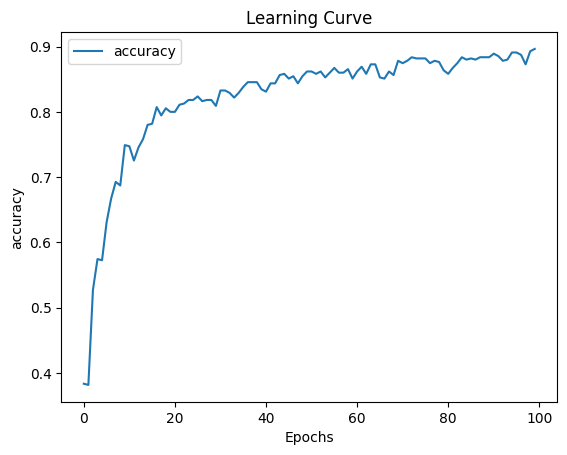

In [75]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [76]:
y_pred_nn = np.argmax(nn_model.predict(X_test_scaled), axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [77]:
y_pred_nn

array([3, 3, 1, 3, 2, 2, 2, 2, 3, 1, 1, 2, 2, 0, 2, 2, 3, 3, 3, 2, 2, 3,
       1, 2, 3, 0, 2, 0, 3, 1, 2, 0, 3, 0, 2, 0, 3, 0, 2, 0, 3, 2, 3, 3,
       0, 3, 0, 3, 2, 2, 2, 3, 2, 3, 0, 2, 3, 2, 3, 2, 3, 0, 2, 3, 1, 1,
       2, 1, 0, 3, 1, 1, 2, 3, 3, 0, 0, 0, 2, 1, 1, 3, 0, 1, 3, 1, 0, 2,
       0, 1, 2, 1, 3, 1, 1, 0, 2, 3, 3, 2, 3, 2, 1, 2, 3, 3, 2, 1, 3, 0,
       2, 1, 3, 2, 3, 1, 2, 0, 0, 2, 2, 2, 1, 0, 2, 0, 1, 2, 2, 0, 1, 2,
       3, 1, 0, 2, 2, 3])

In [78]:
from sklearn.metrics import accuracy_score

In [79]:
accuracy_score(y_pred_nn,y_test)

0.7898550724637681

<u>Forecasts</u>

In [80]:
X_new_values = forecast_df[['wind_speed', 'wind_dir', 'swell_height', 'swell_period', 'swell_dir']]

In [81]:
y_new_values = forest_best.predict(X_new_values)

In [82]:
X_new_values

,wind_speed,wind_dir,swell_height,swell_period,swell_dir
0,12,313,0.5,4,313
1,14,301,0.5,3,306
2,15,307,0.8,4,306
3,16,303,0.7,4,304
4,18,296,0.7,4,300
...,...,...,...,...,...
95,9,21,0.4,3,26
96,11,21,0.5,3,30
97,13,17,0.5,3,27
98,13,49,0.6,4,38


In [83]:
X_new_values_scaled = X_new_values.copy()

In [84]:
X_new_values_scaled[['wind_speed', 'wind_dir', 'swell_dir']] = minmax_scaler.transform(X_new_values[['wind_speed', 'wind_dir', 'swell_dir']])
X_new_values_scaled[['swell_height', 'swell_period']] = standard_scaler.transform(X_new_values[['swell_height', 'swell_period']])

In [85]:
y_new_values = xgb_best.predict(X_new_values_scaled)

In [86]:
y_new_values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [87]:
forecast_df['note'] = y_new_values

In [88]:
forecast_df[forecast_df.note == 2]

,date,wind_speed,swell_height,swell_period,wind_dir,swell_dir,note
33,Th\n4.\n19h,14,0.5,9,311,299,2
